## Additional pre-processing: scaling, centering, missing data testing

In [1]:
#load necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style','default')
%matplotlib inline

%load_ext rmagic
#http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb
#http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html
import re
import pygal

import subprocess as sp
import shlex

from joblib import Parallel, delayed  
import multiprocessing


#https://docs.python.org/2/library/collections.html

In [2]:
%%R
#http://www.magesblog.com/2013/04/how-to-change-alpha-value-of-colours-in.html
#library(scales)
## Add an alpha value to a colour
add.alpha <- function(col, alpha=1){
  if(missing(col))
    stop("Please provide a vector of colours.")
  apply(sapply(col, col2rgb)/255, 2, 
                     function(x) 
                       rgb(x[1], x[2], x[3], alpha=alpha))  
}
        
        



If you look at the *../SEPTEMBER_2014/original_SQL_without_dupes_from_R.csv* file, you will find de-duped data, with duplicate columns merged on average value. All the categorical, metadata and integer columns are still in though. Since we are interested in **metaphase** spindles only, the dataset of interest is filtered on ***stage*** column (*../SEPTEMBER_2014/original_SQL_WO_dupes_WO_meta_from_R.csv*). We will subset it on numerical columns before putting missing values back in.

In [3]:
input_df=pd.read_csv('../SEPTEMBER_2014/original_SQL_metaphase_only_from_R.csv')

In [4]:
input_df.head() #unnamed is 'row name in the R df'

,Unnamed: 0,date,image,objective,time_pf,num_of_cells,meiotic,stage,cell_diameter_um,spindle_length__asters_um,...,phylum_CAT,organism_CAT,cleavage_type_CAT,fixation_CAT,microscope_CAT,stage_CAT,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG
0,2,2013-11-06 00:00:00,131106batstar_35hpf_6,40x,210,1,0,m,163.05828,24.85329,...,1,1,1,1,1,2,0.00000,6.985440,NaN,36.245055
1,4,2013-11-06 00:00:00,131106batstar_35hpf_10,40x,210,1,0,m,194.04000,42.39774,...,1,1,1,1,1,2,0.00000,8.764140,8.23053,38.953530
2,6,2013-11-06 00:00:00,131106batstar_35hpf_12_top,40x,210,2,0,m,149.05506,32.71191,...,1,1,1,1,1,2,NaN,5.974815,10.55901,NaN
3,7,2013-11-06 00:00:00,131106batstar_35hpf_12_bottom,40x,210,2,0,m,150.36483,31.28895,...,1,1,1,1,1,2,4.62462,5.433120,10.55901,NaN
4,10,2013-11-06 00:00:00,131106batstar_35hpf_23,40x,210,1,0,m,181.28187,42.52710,...,1,1,1,1,1,2,3.79995,9.419025,10.55901,36.891855


Using code from *Keynote_plots_R_p9_unsupervised.R*

In [5]:
input_df.phylum.replace('Chordaya','chordata',inplace=True)

In [6]:
%%R 
continuous.vars<-c("cell_diameter_um","distance_between_chromosomes_um","genome","metaphase_plate_aspect_ratio_um","metaphase_plate_lengt_h_um","metaphase_plate_width_um","spindle_aspect_ratio_asters_um","spindle_aspect_ratio_poles_um","spindle_length__asters_um","spindle_length_poles_um","spindle_width_um","astere.to.pole_distance_AVG","inner_aster_diameter_AVG","polar_body_diameter_AVG","outer_aster_diameter_AVG")
continuous_vars<-continuous.vars

In [7]:
%Rpull continuous_vars

In [8]:
input_df.columns.shape, continuous_vars.shape

((41,), (15,))

In [9]:
continuous_vars.tolist()

['cell_diameter_um',
 'distance_between_chromosomes_um',
 'genome',
 'metaphase_plate_aspect_ratio_um',
 'metaphase_plate_lengt_h_um',
 'metaphase_plate_width_um',
 'spindle_aspect_ratio_asters_um',
 'spindle_aspect_ratio_poles_um',
 'spindle_length__asters_um',
 'spindle_length_poles_um',
 'spindle_width_um',
 'astere.to.pole_distance_AVG',
 'inner_aster_diameter_AVG',
 'polar_body_diameter_AVG',
 'outer_aster_diameter_AVG']

In [10]:
print input_df[continuous_vars].shape
input_df[continuous_vars].head()

(1462, 15)


,cell_diameter_um,distance_between_chromosomes_um,genome,metaphase_plate_aspect_ratio_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG
0,163.05828,0,811,3.744966,9.02286,2.40933,2.491086,1.833063,24.85329,18.28827,9.97689,0.00000,6.985440,NaN,36.245055
1,194.04000,0,811,1.919679,7.72926,4.02633,2.427778,2.427778,42.39774,42.39774,17.46360,0.00000,8.764140,8.23053,38.953530
2,149.05506,0,811,1.744565,10.38114,5.95056,2.845288,1.931083,32.71191,22.20141,11.49687,NaN,5.974815,10.55901,NaN
3,150.36483,0,811,2.298013,11.22198,4.88334,2.526110,1.449086,31.28895,17.94870,12.38622,4.62462,5.433120,10.55901,NaN
4,181.28187,0,811,2.247978,13.48578,5.99907,3.022989,1.942529,42.52710,27.32730,14.06790,3.79995,9.419025,10.55901,36.891855


In [11]:
input_df[continuous_vars].columns

Index([u'cell_diameter_um', u'distance_between_chromosomes_um', u'genome', u'metaphase_plate_aspect_ratio_um', u'metaphase_plate_lengt_h_um', u'metaphase_plate_width_um', u'spindle_aspect_ratio_asters_um', u'spindle_aspect_ratio_poles_um', u'spindle_length__asters_um', u'spindle_length_poles_um', u'spindle_width_um', u'astere.to.pole_distance_AVG', u'inner_aster_diameter_AVG', u'polar_body_diameter_AVG', u'outer_aster_diameter_AVG'], dtype='object')

In [12]:
input_df[np.append(continuous_vars,'organism')].head()

,cell_diameter_um,distance_between_chromosomes_um,genome,metaphase_plate_aspect_ratio_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG,organism
0,163.05828,0,811,3.744966,9.02286,2.40933,2.491086,1.833063,24.85329,18.28827,9.97689,0.00000,6.985440,NaN,36.245055,asterina_miniata
1,194.04000,0,811,1.919679,7.72926,4.02633,2.427778,2.427778,42.39774,42.39774,17.46360,0.00000,8.764140,8.23053,38.953530,asterina_miniata
2,149.05506,0,811,1.744565,10.38114,5.95056,2.845288,1.931083,32.71191,22.20141,11.49687,NaN,5.974815,10.55901,NaN,asterina_miniata
3,150.36483,0,811,2.298013,11.22198,4.88334,2.526110,1.449086,31.28895,17.94870,12.38622,4.62462,5.433120,10.55901,NaN,asterina_miniata
4,181.28187,0,811,2.247978,13.48578,5.99907,3.022989,1.942529,42.52710,27.32730,14.06790,3.79995,9.419025,10.55901,36.891855,asterina_miniata


Now the 'organism' categorical column is at the very end.

In [13]:
input_df.meiotic.head()

0    0
1    0
2    0
3    0
4    0
Name: meiotic, dtype: int64

In [14]:
input_df_cont_wORG=input_df[np.append(continuous_vars,['organism','meiotic'])]

In [15]:
input_df_cont_wORG.columns[-2:]

Index([u'organism', u'meiotic'], dtype='object')

### Random sampling from data grouped by organism and spindle type.

#### 1. The grouping part.

In [21]:
groups=input_df_cont_wORG.groupby(['organism','meiotic'])

In [22]:
groups_map_NAs=input_df_cont_wORG.groupby(['organism','meiotic'])

Comment out the code below if you want to see what the groups look like.

In [23]:
#for item in groups.groups.items():
#    print(item) #the key is a tuple - call it by: #groups.groups[('Callithrix_jacchus',1)]

The function will need 'group', 'column', testing for missing values and NA-filler.

In [24]:
def col_with_NAs(col):
    '''Tests whether a column (series) passed contains any missing values'''
    if np.sum(col.isnull()) !=0:
        return True
    else:
        return False

In [25]:
def bootstrap_nan(data_frame, column):
    '''takes data frame or subsetted data frame and the column (variable) name and returns
    mean of 100 values sampled from the group'''
    sampled=np.random.choice(data_frame[column][data_frame.index],size=100)
    #print np.random.choice(data_frame[column][data_frame.index],size=100)
    #return np.nanmean(np.random.choice(data_frame[column][data_frame.index],size=100))
    #print sampled
    k=np.nan
    while np.isnan(k) == True:
        k=np.random.choice(sampled)
        #print k
    else:
        return k

In [26]:
def NA_filler(group_as_df, column):
    for i in group_as_df[column].index:
        if np.isnan(group_as_df[column][i])==True:
            group_as_df[column].loc[i]=bootstrap_nan(group_as_df, column)

Comment out the lines below if you want to see the outcome of grouping. These are the values to be used for the row-indexing 
of the the data frame.

In [27]:
#for key in groups_map_NAs.groups.keys():
#    print key #groups_map_NAs.groups[key]

In [28]:
input_df_cont_wORG_filled =input_df_cont_wORG.copy()

In [29]:
testing=input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:]

In [ ]:
for group in groups_map_NAs.groups:
    for col in input_df_cont_wORG_filled.columns:
    #print groups_map_NAs.groups[group]
        if col_with_NAs(input_df_cont_wORG_filled.iloc[groups_map_NAs.groups[group],:][col])==True:
            #print group, col
            NA_filler(input_df_cont_wORG_filled.iloc[groups_map_NAs.groups[group],:],col)

In [ ]:
input_df_cont_wORG_filled.head()

In [228]:
#groups_map_NAs.groups[('Homo_sapiens', 1)]

In [229]:
#testing=input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:]

In [243]:
groups_map_NAs.groups[('Homo_sapiens', 1)]

[1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232]

In [237]:
input_df_cont_wORG.iloc[groups_map_NAs.groups[('Homo_sapiens', 1)],:]

,cell_diameter_um,distance_between_chromosomes_um,genome,metaphase_plate_aspect_ratio_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG,organism,meiotic
1225,138.4710,0,3381,2.512821,14.84700,5.90850,1.286364,1.286364,21.43725,21.43725,16.66500,0,0,12.119515,0,Homo_sapiens,1
1226,NaN,0,3381,3.494118,22.49775,6.43875,1.199203,1.199203,22.80075,22.80075,19.01325,0,0,13.874640,0,Homo_sapiens,1
1227,NaN,0,3381,3.681818,11.56680,3.14160,1.211009,1.211009,13.19472,13.19472,10.89564,0,0,13.874640,0,Homo_sapiens,1
1228,NaN,0,3381,4.842593,10.46000,2.16000,1.333333,1.333333,11.92000,11.92000,8.94000,0,0,13.874640,0,Homo_sapiens,1
1229,NaN,0,3381,3.232804,12.22000,3.78000,1.062385,1.062385,11.58000,11.58000,10.90000,0,0,13.874640,0,Homo_sapiens,1
1230,NaN,0,3381,3.924051,12.40000,3.16000,1.460722,1.460722,13.76000,13.76000,9.42000,0,0,13.874640,0,Homo_sapiens,1
1231,NaN,0,3381,3.206294,8.72984,2.72272,1.579940,1.579940,15.14632,15.14632,9.58664,0,0,13.874640,0,Homo_sapiens,1
1232,129.7628,0,3381,3.275862,13.96880,4.26416,1.219697,1.219697,11.83672,11.83672,9.70464,0,0,10.915755,0,Homo_sapiens,1


In [44]:
col_with_NAs(input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].cell_diameter_um)

True

In [45]:
col_with_NAs(input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].genome)

False

In [50]:
input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].cell_diameter_um

1225    138.4710
1226         NaN
1227         NaN
1228         NaN
1229         NaN
1230         NaN
1231         NaN
1232    129.7628
Name: cell_diameter_um, dtype: float64

In [37]:
input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].isnull()

,cell_diameter_um,distance_between_chromosomes_um,genome,metaphase_plate_aspect_ratio_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG,organism,meiotic
1225,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1226,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1227,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1228,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1229,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1230,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1231,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1232,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [54]:
input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].isnull().groupby('cell_diameter_um').groups

{False: [1225, 1232], True: [1226, 1227, 1228, 1229, 1230, 1231]}

In [58]:
value=[]
for idx in input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].isnull().groupby('cell_diameter_um').groups[True]:
    print idx


1226
1227
1228
1229
1230
1231


In [59]:
to_replace =input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].isnull().groupby('cell_diameter_um').groups[True]

In [60]:
to_replace

[1226, 1227, 1228, 1229, 1230, 1231]

In [71]:
grouped_df_test=input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:]

In [221]:
def bootstrap_nan(data_frame, column):
    '''takes data frame or subsetted data frame and the column (variable) name and returns
    mean of 100 values sampled from the group'''
    sampled=np.random.choice(data_frame[column][data_frame.index],size=100)
    #print np.random.choice(data_frame[column][data_frame.index],size=100)
    #return np.nanmean(np.random.choice(data_frame[column][data_frame.index],size=100))
    #print sampled
    k=np.nan
    while np.isnan(k) == True:
        k=np.random.choice(sampled)
        print k
    else:
        return k

In [224]:
bootstrap_nan(testing,'cell_diameter_um')

nan
nan
nan
nan
nan
nan
nan
nan
138.471


138.471

In [189]:
testing=input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:]

In [182]:
def NA_filler(group_as_df, column):
    for i in group_as_df[column].index:
        if np.isnan(group_as_df[column][i])==True:
            group_as_df[column].loc[i]=bootstrap_nan(group_as_df, column)

In [185]:
NA_filler(testing,'cell_diameter_um')

-c:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [102]:
testing=input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:]

In [157]:
for i in testing.cell_diameter_um.index:
    #print i
    #print testing.cell_diameter_um[i]
     if np.isnan(testing.cell_diameter_um[i]):
    #    i=50
        testing.cell_diameter_um[i]=0

In [158]:
testing

,cell_diameter_um,distance_between_chromosomes_um,genome,metaphase_plate_aspect_ratio_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG,organism,meiotic
1225,138.4710,0,3381,2.512821,14.84700,5.90850,1.286364,1.286364,21.43725,21.43725,16.66500,0,0,12.119515,0,Homo_sapiens,1
1226,0.0000,0,3381,3.494118,22.49775,6.43875,1.199203,1.199203,22.80075,22.80075,19.01325,0,0,13.874640,0,Homo_sapiens,1
1227,0.0000,0,3381,3.681818,11.56680,3.14160,1.211009,1.211009,13.19472,13.19472,10.89564,0,0,13.874640,0,Homo_sapiens,1
1228,0.0000,0,3381,4.842593,10.46000,2.16000,1.333333,1.333333,11.92000,11.92000,8.94000,0,0,13.874640,0,Homo_sapiens,1
1229,0.0000,0,3381,3.232804,12.22000,3.78000,1.062385,1.062385,11.58000,11.58000,10.90000,0,0,13.874640,0,Homo_sapiens,1
1230,0.0000,0,3381,3.924051,12.40000,3.16000,1.460722,1.460722,13.76000,13.76000,9.42000,0,0,13.874640,0,Homo_sapiens,1
1231,0.0000,0,3381,3.206294,8.72984,2.72272,1.579940,1.579940,15.14632,15.14632,9.58664,0,0,13.874640,0,Homo_sapiens,1
1232,129.7628,0,3381,3.275862,13.96880,4.26416,1.219697,1.219697,11.83672,11.83672,9.70464,0,0,10.915755,0,Homo_sapiens,1


In [35]:
np.sum(input_df_cont_wORG.iloc[groups_map_NAs.cell_diameter_um.groups[('Homo_sapiens', 1)],:].isnull())

cell_diameter_um                   6
distance_between_chromosomes_um    0
genome                             0
metaphase_plate_aspect_ratio_um    0
metaphase_plate_lengt_h_um         0
metaphase_plate_width_um           0
spindle_aspect_ratio_asters_um     0
spindle_aspect_ratio_poles_um      0
spindle_length__asters_um          0
spindle_length_poles_um            0
spindle_width_um                   0
astere.to.pole_distance_AVG        0
inner_aster_diameter_AVG           0
polar_body_diameter_AVG            0
outer_aster_diameter_AVG           0
organism                           0
meiotic                            0
dtype: int64

In [21]:
input_df_cont_wORG.cell_diameter_um[[12,13]]

12    179.08408
13    229.90000
Name: cell_diameter_um, dtype: float64

In [22]:
medians=[]
def bootstrap_nan(data_frame, column, indices):
    
    '''for a given column (variable), sample with data with replacement (bootstrap as many values as the column has) 
    and calculate median for the sample. Do it 100 times. For each column, returns vector of size 100. From this vector, 
    randomly choose 1'''
    
    for i in xrange(0,100): 
        medians.append(np.nanmedian(np.random.choice(data_frame[column][indices],size=len(data_frame[column]))))
    return np.random.choice(medians)

#TEST:
bootstrap_nan(input_df_cont_wORG,'cell_diameter_um',range(0,len(input_df_cont_wORG.cell_diameter_um)))

73.900000000000006

In [23]:
results=[]

for group in groups.groups.values():
    #print group
    #print input_df_cont_wORG['cell_diameter_um'][group]
    results.append(bootstrap_nan(input_df_cont_wORG, 'cell_diameter_um',group))

print(results)
len(results) 

[138.471, 138.471, 222.40880000000001, 221.65836000000002, 134.11689999999999, 795.61320000000001, 795.61320000000001, 221.80389, 221.65836000000002, 83.0, 23.224599999999999, 221.65836000000002, 221.80389, nan, 795.61320000000001, 77.066220000000001, 35.202090000000005, 31.0, 84.700000000000003, 36.738240000000005, 282.86413999999996, 48.5, 34.587629999999997, 73.266269999999992, 68.285910000000001, 35.5, 12.43473, 20.904389999999999, 49.803600000000003, 30.899999999999999, 123.1367]


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


31

In [54]:
##### TEST CELL #####
from joblib import Parallel, delayed  
import multiprocessing

inputs = range(100)  
def processInput(i):  
    return i * i

num_cores = multiprocessing.cpu_count()

print("numCores = " + str(num_cores))

results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)  

print(results)
##### END OF TEST CELL #####

numCores = 4
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


In [55]:
from joblib import Parallel, delayed  
import multiprocessing

inputs = input_df_cont_wORG.columns[:-2]
len(inputs)

num_cores=multiprocessing.cpu_count()
print('cores available: ' + str(num_cores))

results=Parallel(n_jobs=num_cores)(delayed(bootstrap_nan)(input_df_cont_wORG,col,range(0,len(input_df_cont_wORG[col]))) for col in inputs)

cores available: 4


In [56]:
len(results)

15

In [57]:
results

[175.40000000000001,
 175.40000000000001,
 175.40000000000001,
 175.40000000000001,
 20.904389999999999,
 20.904389999999999,
 20.904389999999999,
 20.904389999999999,
 1181.84878,
 1181.84878,
 1181.84878,
 1181.84878,
 73.153080000000003,
 73.153080000000003,
 73.153080000000003]

In [58]:
np.nanmedian(np.random.choice(input_df_cont_wORG.cell_diameter_um,size=len(input_df_cont_wORG.cell_diameter_um)))

73.900000000000006

In [59]:
np.mean(input_df_cont_wORG.cell_diameter_um)

116.15803588028169

The idea behind dealing with missing values is: 

    for each column (variable):
        test for missing value
        if it exists 
        randomly sample remaining ones, calculate median - do it 100 times and from these 100, randomly choose 1.
        

## Fast-forward: using *caret's* bagged-tree fill-na method. Cluster on the output (continous data). Elbow curve (SSQ/intertia). Chi-square for categories.

I. Pull the processed data from R (script: *Keynote_plots_R_p9_unsupervised.R*)

In [60]:
baggedTree_df=pd.read_csv('../SEPTEMBER_2014/original_SQL_continuous_only_baggedTree.csv')

In [61]:
baggedTree_df.head()

,Unnamed: 0,cell_diameter_um,spindle_length__asters_um,spindle_length_poles_um,spindle_width_um,spindle_aspect_ratio_asters_um,spindle_aspect_ratio_poles_um,metaphase_plate_lengt_h_um,metaphase_plate_width_um,metaphase_plate_aspect_ratio_um,distance_between_chromosomes_um,genome,astere.to.pole_distance_AVG,inner_aster_diameter_AVG,polar_body_diameter_AVG,outer_aster_diameter_AVG
0,2,163.05828,24.85329,18.28827,9.97689,2.491086,1.833063,9.02286,2.40933,3.744966,0,811,0.000000,6.985440,7.187253,36.245055
1,4,194.04000,42.39774,42.39774,17.46360,2.427778,2.427778,7.72926,4.02633,1.919679,0,811,0.000000,8.764140,8.230530,38.953530
2,6,149.05506,32.71191,22.20141,11.49687,2.845288,1.931083,10.38114,5.95056,1.744565,0,811,2.826213,5.974815,10.559010,30.819385
3,7,150.36483,31.28895,17.94870,12.38622,2.526110,1.449086,11.22198,4.88334,2.298013,0,811,4.624620,5.433120,10.559010,29.389583
4,10,181.28187,42.52710,27.32730,14.06790,3.022989,1.942529,13.48578,5.99907,2.247978,0,811,3.799950,9.419025,10.559010,36.891855


In [62]:
baggedTree_df2=baggedTree_df.copy()

In [63]:
baggedTree_df2.columns

Index([u'Unnamed: 0', u'cell_diameter_um', u'spindle_length__asters_um', u'spindle_length_poles_um', u'spindle_width_um', u'spindle_aspect_ratio_asters_um', u'spindle_aspect_ratio_poles_um', u'metaphase_plate_lengt_h_um', u'metaphase_plate_width_um', u'metaphase_plate_aspect_ratio_um', u'distance_between_chromosomes_um', u'genome', u'astere.to.pole_distance_AVG', u'inner_aster_diameter_AVG', u'polar_body_diameter_AVG', u'outer_aster_diameter_AVG'], dtype='object')

In [64]:
col_to_drop=baggedTree_df2.columns[0]

In [65]:
baggedTree_df2.drop(col_to_drop,axis=1,inplace=True)

In [66]:
np.shape(baggedTree_df2.values) #correct dimensions should be 1462 to 15

(1462, 15)

In [67]:
array_for_cluster=baggedTree_df2.values

In [68]:
baggedTree_df2.columns[9]

'distance_between_chromosomes_um'

In [69]:
#%whos
#%xdel array_for_clusetr 

II. As variables are on different scales, scale and center.

In [70]:
from sklearn import preprocessing

In [71]:
scaler=preprocessing.StandardScaler().fit(array_for_cluster)

In [72]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
scaler.mean_

array([  1.21555633e+02,   2.92002390e+01,   2.14831870e+01,
         1.10273595e+01,   2.68114170e+00,   2.03638185e+00,
         1.13026400e+01,   3.95497652e+00,   3.03136940e+00,
         2.48145486e-02,   1.12958988e+03,   1.21568578e+00,
         6.72012166e+00,   9.13449873e+00,   3.10238265e+01])

In [74]:
scaler.std_

array([  1.79620542e+02,   1.59804804e+01,   1.06139092e+01,
         4.74357457e+00,   1.14364783e+00,   8.03895109e-01,
         4.09800387e+00,   1.53776618e+00,   1.09338352e+00,
         6.02652648e-01,   1.03118993e+03,   2.16192939e+00,
         5.41516230e+00,   5.17452468e+00,   2.26297346e+01])

In [75]:
array_for_cluster_scaled=preprocessing.scale(array_for_cluster)

In [76]:
array_for_cluster_scaled[0,:]

array([ 0.23105735, -0.27201616, -0.30101228, -0.22145104, -0.16618385,
       -0.25291688, -0.55631476, -1.00512454,  0.65265026, -0.04117554,
       -0.30895364, -0.56231521,  0.04899546, -0.37631392,  0.23072425])

In [77]:
scaler.inverse_transform(array_for_cluster_scaled[0,:])

array([  1.63058280e+02,   2.48532900e+01,   1.82882700e+01,
         9.97689000e+00,   2.49108590e+00,   1.83306321e+00,
         9.02286000e+00,   2.40933000e+00,   3.74496644e+00,
        -3.71230824e-16,   8.11000000e+02,  -8.88178420e-16,
         6.98544000e+00,   7.18725307e+00,   3.62450550e+01])

In [78]:
array_for_cluster[0,:]

array([ 163.05828   ,   24.85329   ,   18.28827   ,    9.97689   ,
          2.4910859 ,    1.83306321,    9.02286   ,    2.40933   ,
          3.74496644,    0.        ,  811.        ,    0.        ,
          6.98544   ,    7.18725307,   36.245055  ])

In [79]:
#array_for_cluster_scaled

In [80]:
#array_for_cluster

III. Cluster the output.    
Uneven class distribution is super problematic. *In lieu* of subsampling (not super clear, what would be the best approach anyway as there are multiple categories in the data set; this should probably be re-assesed later), we will use an approach which does not assume even cluster sizes.

a. [Affinity propagation](http://www.psi.toronto.edu/affinitypropagation/faq.html)

In [81]:
%Rpush array_for_cluster_scaled

In [82]:
array_for_cluster[0,:]

array([ 163.05828   ,   24.85329   ,   18.28827   ,    9.97689   ,
          2.4910859 ,    1.83306321,    9.02286   ,    2.40933   ,
          3.74496644,    0.        ,  811.        ,    0.        ,
          6.98544   ,    7.18725307,   36.245055  ])

In [83]:
%%R
library(apcluster)
dim(array_for_cluster_scaled)


Attaching package: ‘apcluster’

The following object is masked from ‘package:stats’:

    heatmap

[1] 1462   15


In [84]:
%%R
apres1<-apcluster(negDistMat(r=2),array_for_cluster_scaled)

In [85]:
%%R
apres1


APResult object

Number of samples     =  1462 
Number of iterations  =  210 
Input preference      =  -20.03724 
Sum of similarities   =  -2951.616 
Sum of preferences    =  -1562.905 
Net similarity        =  -4514.52 
Number of clusters    =  78 

Exemplars:
   14 18 26 30 59 74 91 113 152 210 226 235 258 280 286 288 295 309 319 351 363 
   385 407 413 435 442 448 463 556 606 624 631 689 690 710 715 729 758 762 765 
   774 791 794 832 888 899 901 902 904 910 925 971 1017 1020 1104 1113 1170 
   1192 1209 1211 1218 1239 1243 1247 1254 1267 1279 1287 1319 1338 1348 1362 
   1369 1379 1381 1388 1390 1448
Clusters:
   Cluster 1, exemplar 14:
      11 14 16 17
   Cluster 2, exemplar 18:
      10 13 18 19 20 21 22 23 24 31 298
   Cluster 3, exemplar 26:
      12 15 26 28 29 81 101 296
   Cluster 4, exemplar 30:
      30
   Cluster 5, exemplar 59:
      32 35 38 40 44 49 51 59 61 62 63 66 67 68 80 88 89 92 99 449 700 702 703 
      704 705 796 807 1115 1139
   Cluster 6, exemplar 74:
    

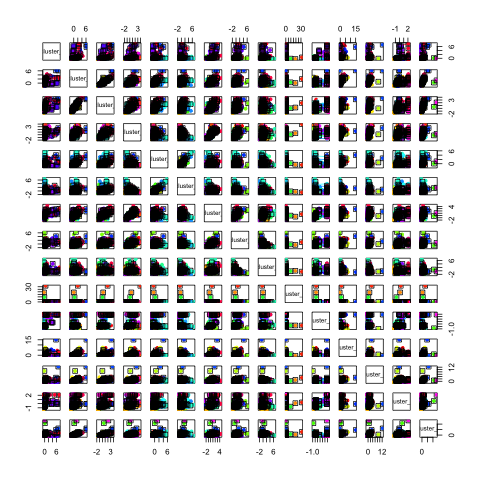

In [86]:
%%R
plot(apres1,array_for_cluster_scaled)

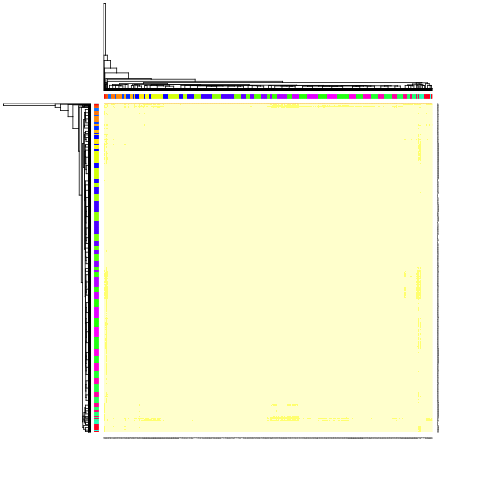

In [87]:
%%R 
heatmap(apres1)

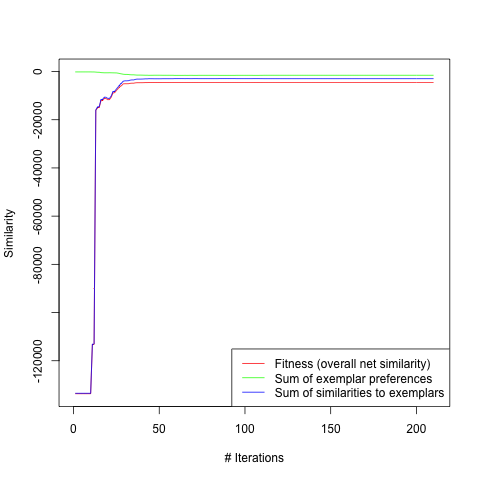

In [88]:
%%R 
apres1c<-apcluster(negDistMat(r=2),array_for_cluster_scaled,details=TRUE)
plot(apres1c)

In [89]:
%R apres1@p

array([-20.03723837])

In [90]:
%R apres1c@p

array([-20.03723837])

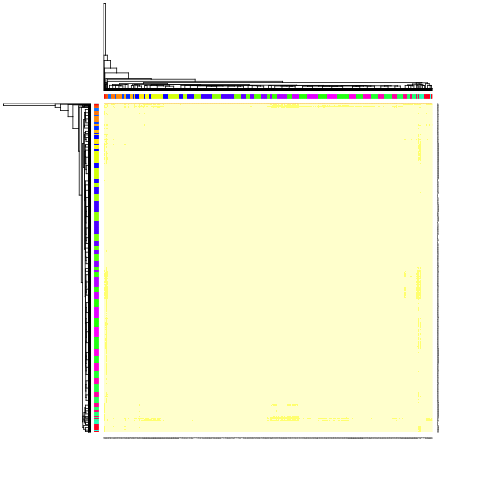

In [91]:
%%R 
heatmap(apres1c)

In [92]:
%%R 
preferenceRange(apres1c@sim)

[1] -2.096170e+04 -1.743454e-05


In [93]:
%%R
apres2<-apcluster(negDistMat(r=2),array_for_cluster_scaled,q=0)
apres2


APResult object

Number of samples     =  1462 
Number of iterations  =  156 
Input preference      =  -1321.706 
Sum of similarities   =  -13129.7 
Sum of preferences    =  -6608.528 
Net similarity        =  -19738.23 
Number of clusters    =  5 

Exemplars:
   634 1176 1181 1309 1384
Clusters:
   Cluster 1, exemplar 634:
      159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 
      177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 
      195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 
      213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 
      231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 259 
      306 307 310 315 318 319 320 323 324 325 328 330 331 334 335 337 345 348 
      349 358 360 363 365 366 368 372 374 397 405 434 436 440 441 442 443 444 
      445 446 452 454 460 465 476 479 480 481 489 492 495 496 497 499 500 501 
      502 503 504 505 506 510 511 512 513

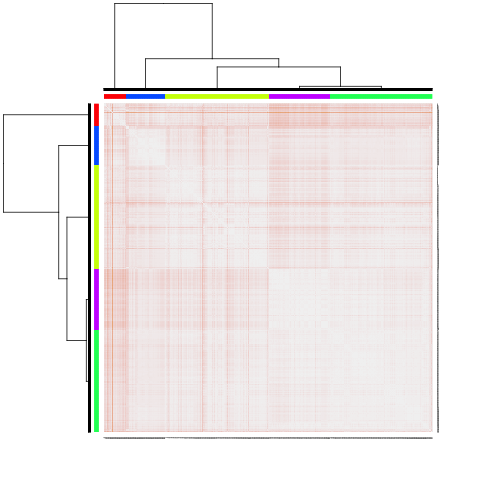

In [213]:
%%R
heatmap(apres2,col=terrain.colors(400))

In [95]:
%%R
aggres1<-aggExCluster(x=apres1c)

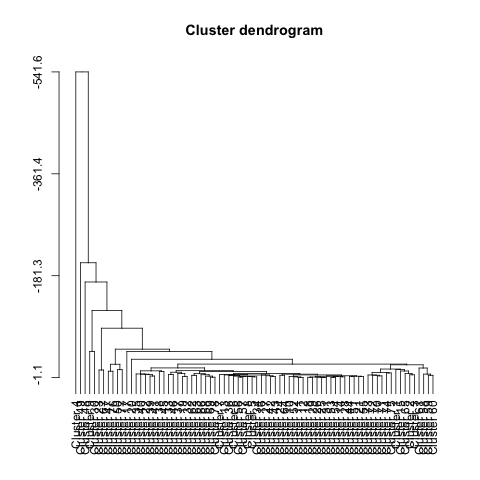

In [96]:
%%R
plot(aggres1)

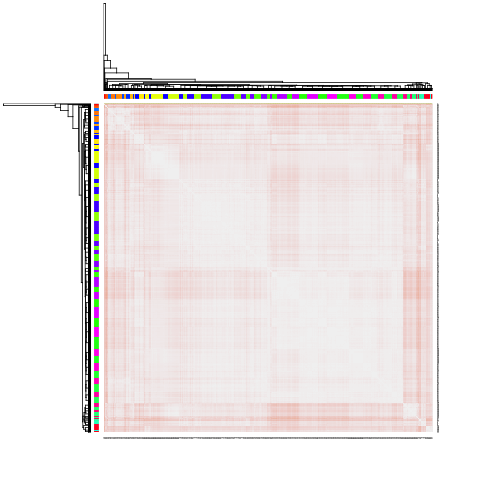

In [212]:
%%R
heatmap(aggres1,col=terrain.colors(400))

In [98]:
%%R
array_for_cluster_scaled_PC<-prcomp(array_for_cluster_scaled,scale=FALSE, center=FALSE)
summary(array_for_cluster_scaled_PC)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.4260 1.5373 1.2375 1.14097 1.00193 0.96369 0.83260
Proportion of Variance 0.3921 0.1574 0.1020 0.08673 0.06688 0.06187 0.04618
Cumulative Proportion  0.3921 0.5495 0.6516 0.73829 0.80517 0.86704 0.91323
                           PC8    PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.66788 0.5212 0.49437 0.38769 0.25602 0.24361 0.23187
Proportion of Variance 0.02972 0.0181 0.01628 0.01001 0.00437 0.00395 0.00358
Cumulative Proportion  0.94294 0.9610 0.97732 0.98734 0.99170 0.99566 0.99924
                          PC15
Standard deviation     0.10686
Proportion of Variance 0.00076
Cumulative Proportion  1.00000


Principle components 1-7 components account for 91% of variation. 

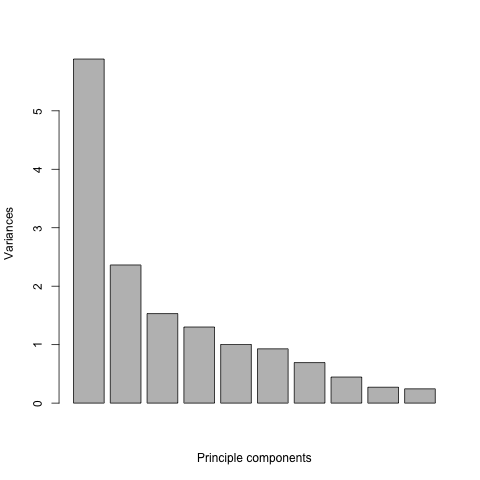

In [99]:
%%R
plot(array_for_cluster_scaled_PC,main=NULL,xlab="Principle components")


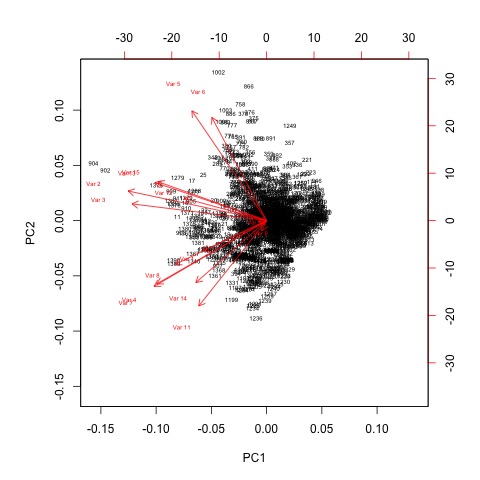

In [100]:
%R biplot(array_for_cluster_scaled_PC,cex=0.5)

Numbers (labels) are the rows of the original data frame. Length of arrows reflects relative loading of particular variables on first and second principle component. All of the variables in red have strong negative loading on principle component 1. Variables 11, 14, 7, 4, 8 have negative loading on principle component 2. 

In [101]:
%%R
array_for_cluster_scaled_PC7<-predict(array_for_cluster_scaled_PC)[,1:7]
head(array_for_cluster_scaled_PC7)

            PC1         PC2         PC3        PC4         PC5          PC6
[1,]  0.9354700  0.32095823 -0.71137992  0.6560423  0.02129765  0.173191352
[2,] -1.3249546  0.46443529  0.23853213 -0.8422328 -0.07853703  0.308200051
[3,] -0.5529065 -0.04750490  0.74062608 -1.5192556 -0.33169053  0.009175603
[4,] -0.3073666 -0.45059908 -0.21066800 -1.1549749 -0.45788416 -0.018326262
[5,] -1.8633050 -0.07523839  0.04213295 -1.2935197 -0.47352391  0.059622490
[6,] -1.2386139 -0.98691728 -0.28196925 -0.7961028 -0.42686560  0.133460092
            PC7
[1,]  0.2481461
[2,]  1.1083341
[3,] -0.6069748
[4,] -1.4446530
[5,] -0.5232893
[6,]  0.2210893


In [102]:
%%R
dim(array_for_cluster_scaled_PC7)

[1] 1462    7


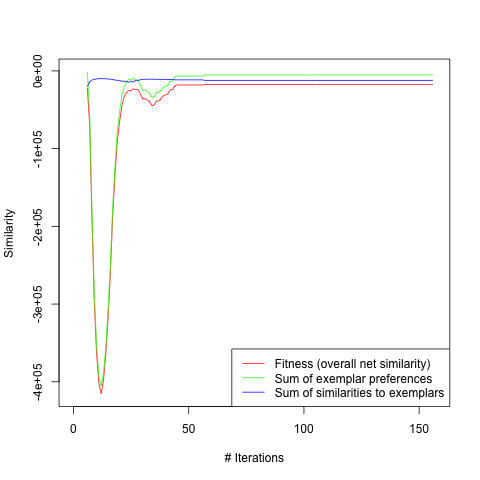

In [103]:
%%R
apres_PCA1<-apcluster(negDistMat(r=2),array_for_cluster_scaled_PC7,details=TRUE,q=0)
plot(apres_PCA1)

In [104]:
%%R
apres_PCA1


APResult object

Number of samples     =  1462 
Number of iterations  =  156 
Input preference      =  -1316.215 
Sum of similarities   =  -12137.56 
Sum of preferences    =  -5264.858 
Net similarity        =  -17402.42 
Number of clusters    =  4 

Exemplars:
   63 649 865 1374
Clusters:
   Cluster 1, exemplar 63:
      2 3 4 5 6 8 9 10 12 13 14 15 18 19 21 26 27 28 29 31 32 33 34 35 36 37 38 
      39 40 41 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59 60 61 62 63 
      64 65 66 67 68 69 70 72 73 74 75 76 77 78 79 80 81 82 84 85 86 87 88 89 
      90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 
      111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 128 129 
      131 132 133 134 135 138 139 140 141 144 146 149 151 152 153 154 155 156 
      157 158 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 
      271 281 283 284 285 287 288 290 291 292 293 294 296 297 298 300 301 302 
      340 351 367 379 394 406 448 449 530 548

In [105]:
%%R
str(apres_PCA1)

Formal class 'APResult' [package "apcluster"] with 18 slots
  ..@ sweeps   : num 0
  ..@ it       : num 156
  ..@ p        : num -1316
  ..@ netsim   : num -17402
  ..@ dpsim    : num -12138
  ..@ expref   : num -5265
  ..@ netsimLev: num(0) 
  ..@ netsimAll: num [1:156] NaN NaN NaN NaN NaN ...
  ..@ dpsimAll : num [1:156] NaN NaN NaN NaN NaN ...
  ..@ exprefAll: num [1:156] NaN NaN NaN NaN NaN ...
  ..@ idxAll   : num [1:1462, 1:156] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:1462] "649" "63" "63" "63" ...
  .. .. ..$ : chr [1:156] "" "" "" "" ...
  ..@ l        : int 1462
  ..@ sel      : num(0) 
  ..@ exemplars: Named num [1:4] 63 649 865 1374
  .. ..- attr(*, "names")= chr [1:4] "63" "649" "865" "1374"
  ..@ clusters :List of 4
  .. ..$ : Named int [1:432] 2 3 4 5 6 8 9 10 12 13 ...
  .. .. ..- attr(*, "names")= chr [1:432] "2" "3" "4" "5" ...
  .. ..$ : Named int [1:653] 1 130 136 143 145 147 159 160 161 162 ...
  .. .. 

In [106]:
%%R
aggres_PCA1<-aggExCluster(x=apres_PCA1)
aggres_PCA1


AggExResult object

Number of samples          =  1462 
Maximum number of clusters =  4 


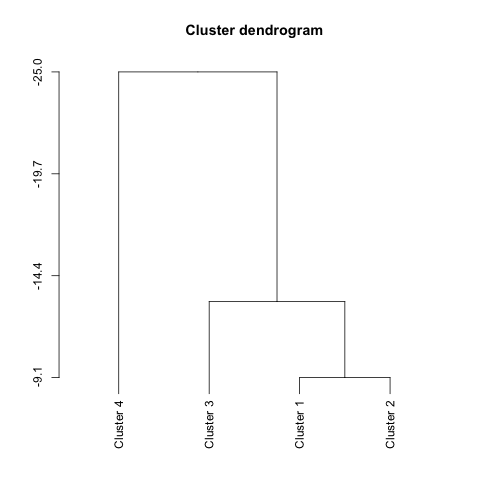

In [107]:
%%R
plot(aggres_PCA1)

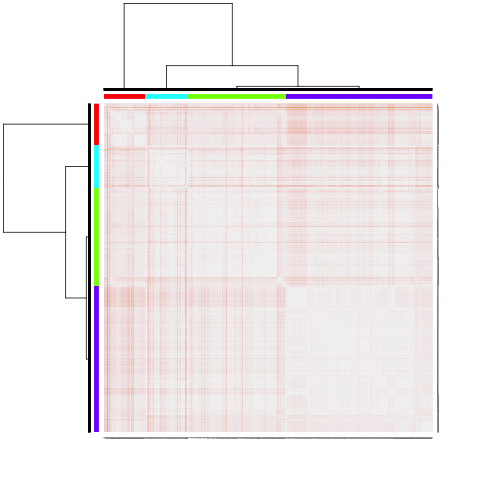

In [207]:
%%R
heatmap(apres_PCA1,scale=FALSE,col=terrain.colors(400))

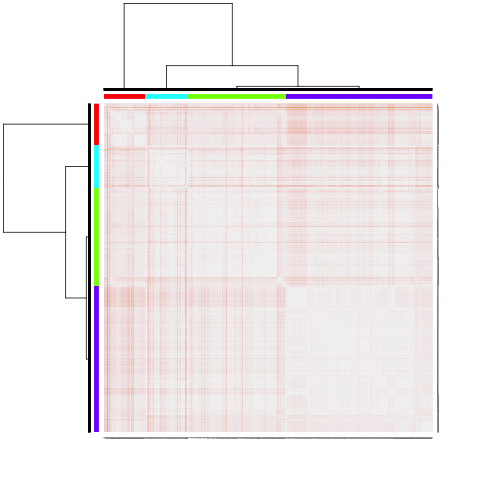

In [300]:
%%R
heatmap(aggres_PCA1,scale=FALSE,col=terrain.colors(400))

In [301]:
%%R
array_for_cluster_PCA_LABs=labels(apres_PCA1,type='enum')
array_for_cluster_AGG_PCA_LABs=labels(aggres_PCA1,type='enum')

array_for_cluster_1<-cbind(array_for_cluster,labels(apres_PCA1,type='enum'))
head(array_for_cluster_2)

         [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]    [,8]
[1,] 163.0583 24.85329 18.28827  9.97689 2.491086 1.833063  9.02286 2.40933
[2,] 194.0400 42.39774 42.39774 17.46360 2.427778 2.427778  7.72926 4.02633
[3,] 149.0551 32.71191 22.20141 11.49687 2.845288 1.931083 10.38114 5.95056
[4,] 150.3648 31.28895 17.94870 12.38622 2.526110 1.449086 11.22198 4.88334
[5,] 181.2819 42.52710 27.32730 14.06790 3.022989 1.942529 13.48578 5.99907
[6,] 160.2770 38.32290 24.67542 15.37767 2.492114 1.604627 15.89511 5.59482
         [,9] [,10] [,11]    [,12]    [,13]     [,14]    [,15] [,16]
[1,] 3.744966     0   811 0.000000 6.985440  7.187253 36.24506     2
[2,] 1.919679     0   811 0.000000 8.764140  8.230530 38.95353     2
[3,] 1.744565     0   811 2.826213 5.974815 10.559010 30.81938     2
[4,] 2.298013     0   811 4.624620 5.433120 10.559010 29.38958     2
[5,] 2.247978     0   811 3.799950 9.419025 10.559010 36.89185     2
[6,] 2.841040     0   811 2.021250 6.977355 10.559010 

In [302]:
%Rpull array_for_cluster_PCA_LABs array_for_cluster_AGG_PCA_LABs

In [304]:
array_for_cluster_PCA_LABs

array([2, 1, 1, ..., 4, 4, 4], dtype=int32)

In [305]:
array_for_cluster_AGG_PCA_LABs

array(['1', '2', '3', '4'], 
      dtype='|S1')

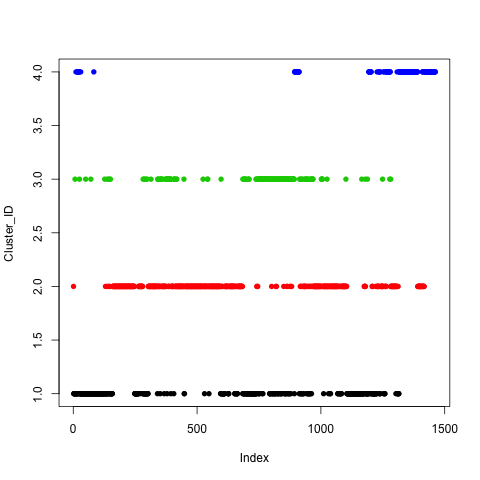

In [187]:
%%R
plot(round(array_for_cluster_1[,16]),col=array_for_cluster_1[,16],pch=16,ylab="Cluster_ID")

In [234]:
%R cat_cols

array(['num_of_cells_CAT', 'classification_CAT', 'phylum_CAT',
       'organism_CAT', 'cleavage_type_CAT', 'fixation_CAT',
       'microscope_CAT', 'stage_CAT', 'num_of_cells', 'classification',
       'phylum', 'organism', 'cleavage_type', 'fixation', 'microscope',
       'stage', 'meiotic', 'centrosome'], 
      dtype='|S18')

In [239]:
phyla=input_df.phylum_CAT
organisms=input_df.organism_CAT
cleavage_type=input_df["cleavage_type_CAT"]
classification=input_df.classification_CAT
fixation=input_df.fixation_CAT
microscope=input_df.microscope_CAT
meiotic=input_df.meiotic
centrosome=input_df.centrosome

In [240]:
%Rpush phyla organisms cleavage_type classification fixation microscope meiotic centrosome

In [227]:
%%R
length(phyla); length(organisms)

[1] 1462


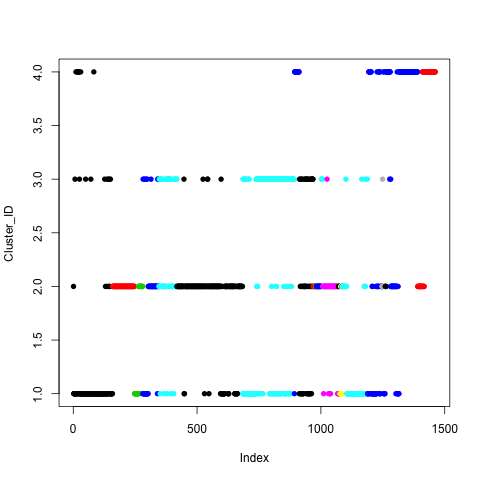

In [221]:
%%R
plot(round(array_for_cluster_1[,16]),col=phyla,pch=16,ylab="Cluster_ID")

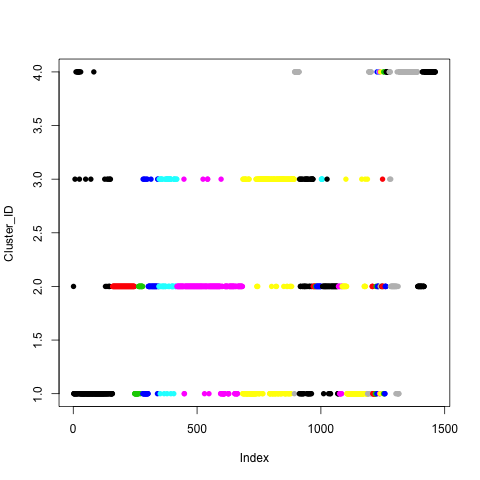

In [228]:
%%R
plot(round(array_for_cluster_1[,16]),col=organisms,pch=16,ylab="Cluster_ID")

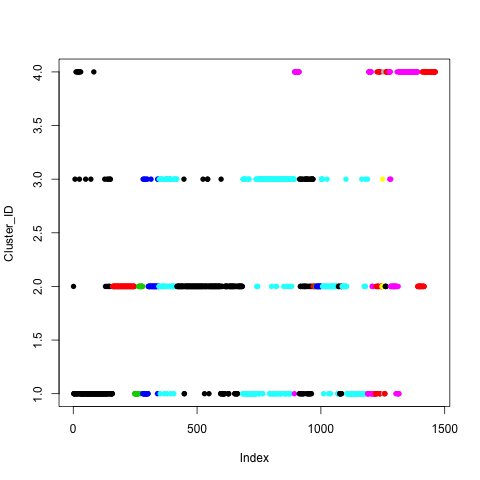

In [233]:
%%R
plot(round(array_for_cluster_1[,16]),col=cleavage_type,pch=16,ylab="Cluster_ID")

In [263]:
np.unique(input_df.classification_CAT)

array([1, 2, 3, 4])

In [275]:
np.unique(input_df.classification)

array(['bd', 'bpe', 'bpl', 'r'], dtype=object)

In [277]:
dict(zip(input_df.classification_CAT,input_df.classification))

{1: 'bd', 2: 'bpe', 3: 'bpl', 4: 'r'}

[1] "#00000066" "#FF000066" "#00CD0066" "#0000FF66"


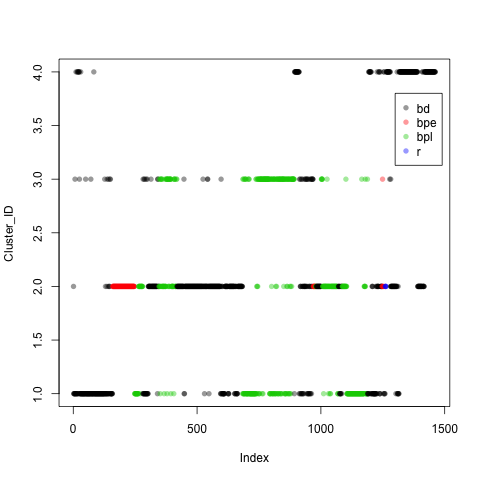

In [288]:
%%R
colors=add.alpha(as.numeric(classification), alpha=0.4)
print(unique(colors))
plot(round(array_for_cluster_1[,16]),col=colors,pch=16,ylab="Cluster_ID")
legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)

In [250]:
meiotic_plt=meiotic+1

In [251]:
centrosome_plt=centrosome+1

In [253]:
%Rpush meiotic_plt centrosome_plt

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
...
1447    0
1448    0
1449    0
1450    0
1451    0
1452    0
1453    0
1454    0
1455    0
1456    0
1457    0
1458    0
1459    0
1460    0
1461    0
Name: centrosome, Length: 1462, dtype: int64

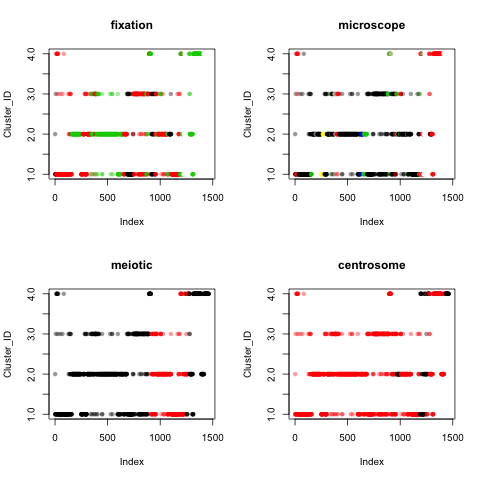

In [311]:
%%R
par(mfrow=c(2,2))
#colors=add.alpha(as.numeric(classification), alpha=0.4)
#print(unique(colors))
#plot(round(array_for_cluster_1[,16]),col=colors,pch=16,ylab="Cluster_ID")
#legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)
#print(add.alpha(as.numeric(centrosome_plt))
#print(as.numeric(centrosome_plt))
plot(round(array_for_cluster_1[,16]),col=add.alpha(as.numeric(fixation),0.4)  ,pch=16,ylab="Cluster_ID",main='fixation')
plot(round(array_for_cluster_1[,16]),col=add.alpha(as.numeric(microscope),0.4),pch=16,ylab="Cluster_ID",main='microscope')
plot(round(array_for_cluster_1[,16]),col=add.alpha(as.numeric(meiotic_plt),0.4),pch=16,main="meiotic",ylab="Cluster_ID")
plot(round(array_for_cluster_1[,16]),col=add.alpha(as.numeric(centrosome_plt),0.4),pch=16,main="centrosome",ylab="Cluster_ID")
#legend(1300,3.8,c('No','Yes'),col=unique(add.alpha(as.numeric(centrosome_plt)),pch=16)
par(mfrow=c(1,1))

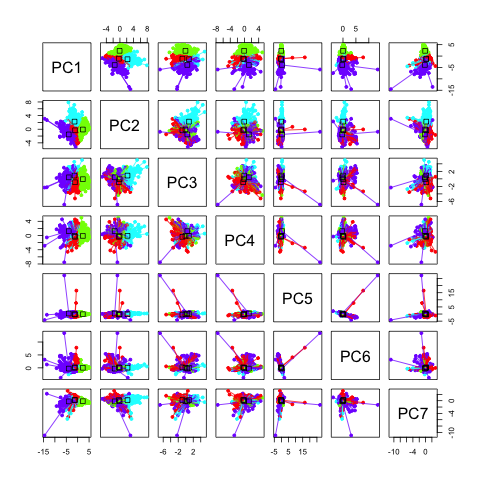

In [109]:
%%R
plot(apres_PCA1,array_for_cluster_scaled_PC7)

In [110]:
%Rpush array_for_cluster

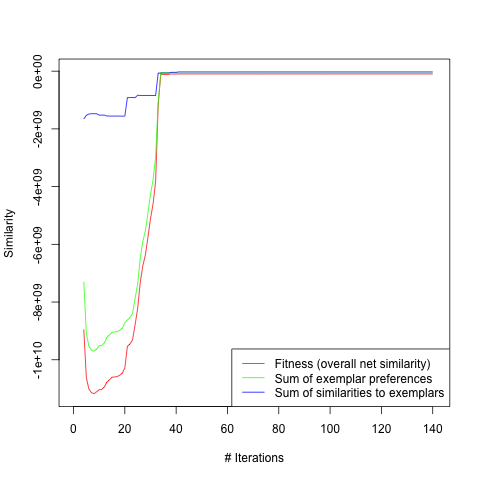

In [111]:
%%R
apres_no_scaling<-apcluster(negDistMat(r=2),array_for_cluster,details=TRUE,q=0)
plot(apres_no_scaling)

In [112]:
%%R
apres_no_scaling


APResult object

Number of samples     =  1462 
Number of iterations  =  140 
Input preference      =  -11647165 
Sum of similarities   =  -26115364 
Sum of preferences    =  -69882989 
Net similarity        =  -95998354 
Number of clusters    =  6 

Exemplars:
   1065 1136 1206 1253 1342 1459
Clusters:
   Cluster 1, exemplar 1065:
      159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 
      177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 
      195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 
      213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 
      231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 281 
      282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 
      300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 
      318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 
      336 337 338 339 340 341 342

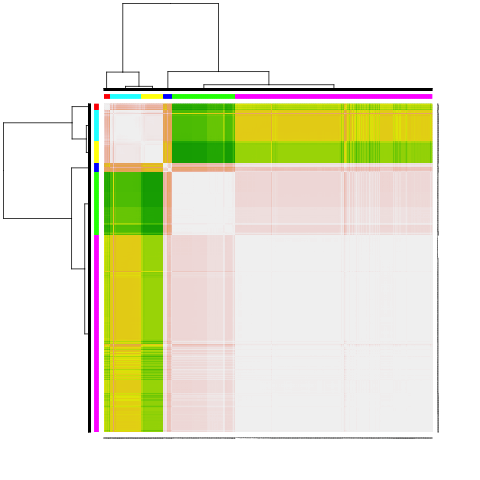

In [214]:
%%R
heatmap(apres_no_scaling,col=terrain.colors(400))

In [114]:
%%R
aggres_no_scaling<-aggExCluster(x=apres_no_scaling)
aggres_no_scaling


AggExResult object

Number of samples          =  1462 
Maximum number of clusters =  6 


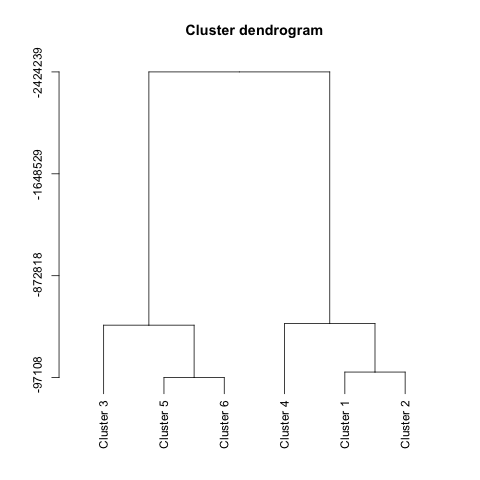

In [115]:
%%R
plot(aggres_no_scaling)

In [116]:
%%R
apres_no_scaling@exemplars

1065 1136 1206 1253 1342 1459 
1065 1136 1206 1253 1342 1459 


In [117]:
%%R
labels(apres_no_scaling,type='enum')
class(array_for_cluster)
array_for_cluster_2<-cbind(array_for_cluster,labels(apres_no_scaling,type='enum'))
head(array_for_cluster_2)

         [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]    [,8]
[1,] 163.0583 24.85329 18.28827  9.97689 2.491086 1.833063  9.02286 2.40933
[2,] 194.0400 42.39774 42.39774 17.46360 2.427778 2.427778  7.72926 4.02633
[3,] 149.0551 32.71191 22.20141 11.49687 2.845288 1.931083 10.38114 5.95056
[4,] 150.3648 31.28895 17.94870 12.38622 2.526110 1.449086 11.22198 4.88334
[5,] 181.2819 42.52710 27.32730 14.06790 3.022989 1.942529 13.48578 5.99907
[6,] 160.2770 38.32290 24.67542 15.37767 2.492114 1.604627 15.89511 5.59482
         [,9] [,10] [,11]    [,12]    [,13]     [,14]    [,15] [,16]
[1,] 3.744966     0   811 0.000000 6.985440  7.187253 36.24506     2
[2,] 1.919679     0   811 0.000000 8.764140  8.230530 38.95353     2
[3,] 1.744565     0   811 2.826213 5.974815 10.559010 30.81938     2
[4,] 2.298013     0   811 4.624620 5.433120 10.559010 29.38958     2
[5,] 2.247978     0   811 3.799950 9.419025 10.559010 36.89185     2
[6,] 2.841040     0   811 2.021250 6.977355 10.559010 

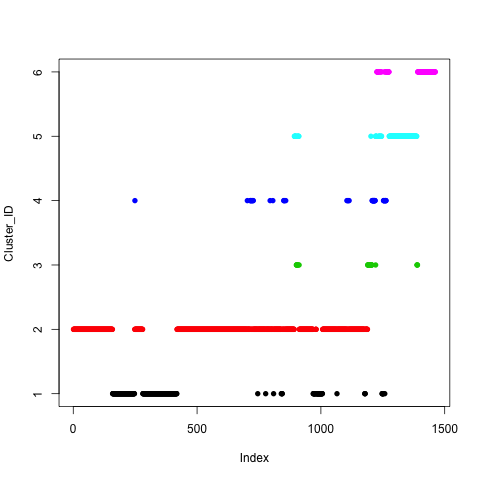

In [180]:
%%R
plot(array_for_cluster_2[,16],col=array_for_cluster_2[,16],pch=16,ylab="Cluster_ID")

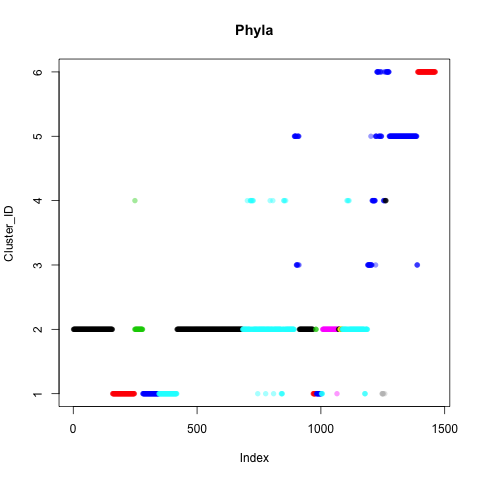

In [322]:
%%R
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(phyla),0.4),pch=16,ylab="Cluster_ID",main='Phyla')

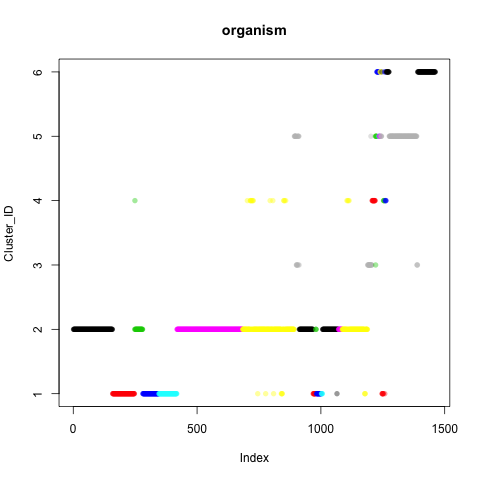

In [319]:
%%R
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(organisms),0.4),pch=16,ylab="Cluster_ID",main="organism")

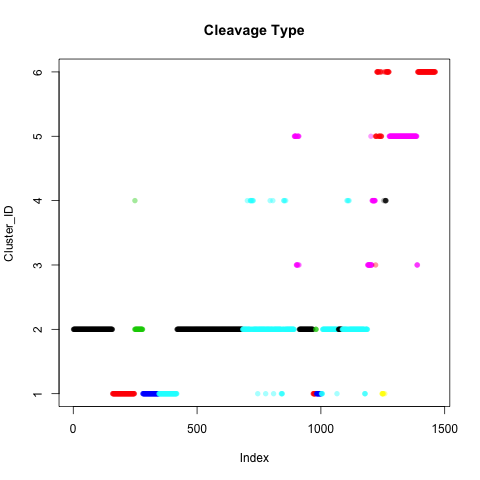

In [323]:
%%R
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(cleavage_type),0.4),pch=16,ylab="Cluster_ID",main='Cleavage Type')

[1] "#00000066" "#FF000066" "#00CD0066" "#0000FF66"


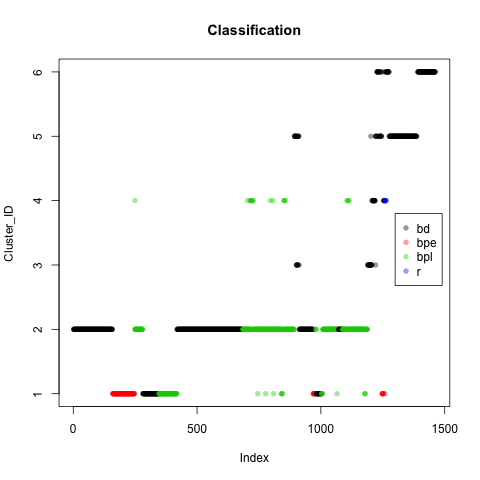

In [325]:
%%R
colors=add.alpha(as.numeric(classification), alpha=0.4)
print(unique(colors))
plot(round(array_for_cluster_2[,16]),col=colors,pch=16,ylab="Cluster_ID",main='Classification')
legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)

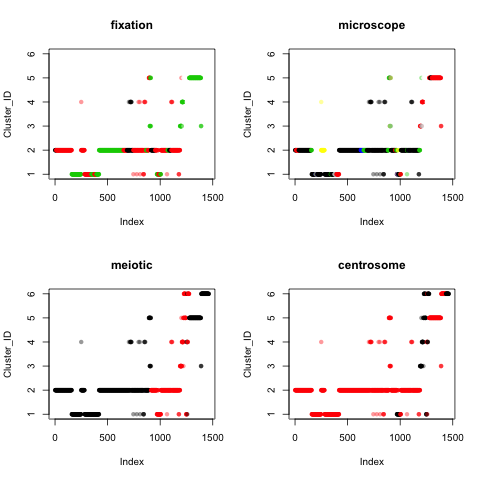

In [326]:
%%R
par(mfrow=c(2,2))
#colors=add.alpha(as.numeric(classification), alpha=0.4)
#print(unique(colors))
#plot(round(array_for_cluster_1[,16]),col=colors,pch=16,ylab="Cluster_ID")
#legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)

plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(fixation),0.4)  ,pch=16,ylab="Cluster_ID",main='fixation')
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(microscope),0.4),pch=16,ylab="Cluster_ID",main='microscope')
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(meiotic_plt),0.4),pch=16,main="meiotic",ylab="Cluster_ID")
plot(round(array_for_cluster_2[,16]),col=add.alpha(as.numeric(centrosome_plt),0.4),pch=16,main="centrosome",ylab="Cluster_ID")
par(mfrow=c(1,1))

In [118]:
%Rpull array_for_cluster_2

In [119]:
array_for_cluster_2[:,-1] #column 16 is the cluster assignment

array([ 2.,  2.,  2., ...,  6.,  6.,  6.])

In [120]:
array_for_cluster_2.shape

(1462, 16)

In [147]:
array_for_cluster_2[:,-1]

array([ 2.,  2.,  2., ...,  6.,  6.,  6.])

Put the categories back in.

In [155]:
%%R
original<-read.csv('../SEPTEMBER_2014/original.csv',stringsAsFactors=FALSE)
original.SQL<-read.csv('../SEPTEMBER_2014/df2_original_for_SQL.csv',stringsAsFactors=FALSE)

grep('_CAT',names(original.SQL),value=TRUE)
cats_to_parse<-grep('_CAT',names(original.SQL),value=TRUE)

strsplit(grep('_CAT',names(original.SQL),value = TRUE)[1],'_CAT')[[1]]
length(sapply(cats_to_parse,function(x){strsplit(x,'_CAT')[[1]]}))
sapply(cats_to_parse,function(x){strsplit(x,'_CAT')[[1]]})

cat.cols<-c(grep('_CAT',names(original.SQL),value=TRUE),sapply(cats_to_parse,function(x){strsplit(x,'_CAT')[[1]]}))
length(cat.cols)
names(cat.cols)<-rep('',length(cat.cols))
cat.cols
cat.cols<-c(cat.cols,'meiotic','centrosome')
#names(original.SQL)
cat_cols<-cat.cols
cat_cols

                                                               
  "num_of_cells_CAT" "classification_CAT"         "phylum_CAT" 
                                                               
      "organism_CAT"  "cleavage_type_CAT"       "fixation_CAT" 
                                                               
    "microscope_CAT"          "stage_CAT"       "num_of_cells" 
                                                               
    "classification"             "phylum"           "organism" 
                                                               
     "cleavage_type"           "fixation"         "microscope" 
                                                               
             "stage"            "meiotic"         "centrosome" 


In [156]:
%Rpull cat_cols

In [159]:
cat_cols

array(['num_of_cells_CAT', 'classification_CAT', 'phylum_CAT',
       'organism_CAT', 'cleavage_type_CAT', 'fixation_CAT',
       'microscope_CAT', 'stage_CAT', 'num_of_cells', 'classification',
       'phylum', 'organism', 'cleavage_type', 'fixation', 'microscope',
       'stage', 'meiotic', 'centrosome'], 
      dtype='|S18')

Test against: classification, phylum, cleavage type

In [165]:
np.unique(input_df['classification'])

array(['bd', 'bpe', 'bpl', 'r'], dtype=object)

In [178]:
np.unique(input_df['phylum'])

array([nan, 'Cnidaria', 'annelida', 'arthropoda', 'chordata',
       'echinodermata', 'mollusca', 'nematoda', 'nemertea'], dtype=object)

In [171]:
#np.unique(input_df.organism[input_df.phylum=='Chordaya'])

array(['mus_musculus'], dtype=object)

In [175]:
#np.unique(input_df.phylum.replace('Chordaya','chordata'))

array([nan, 'Cnidaria', 'annelida', 'arthropoda', 'chordata',
       'echinodermata', 'mollusca', 'nematoda', 'nemertea'], dtype=object)

In [169]:
np.unique(input_df['cleavage_type'])

array(['b', 'dm', 'dra', 'ir', 'rah', 'ro', 's', 'sf', 'sp'], dtype=object)

b. KMeans

In [121]:
#from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn import metrics

In [122]:
len(np.unique(input_df_cont_wORG.organism))

20

In [123]:
#kmeans_1=KMeans(n_clusters=20,random_state=1)

In [124]:
kmeans_1=KMeans(n_clusters=20,random_state=1)
kmeans_1.fit(array_for_cluster_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=1, tol=0.0001,
    verbose=0)

In [125]:
metrics.silhouette_score(array_for_cluster_scaled,kmeans_1.labels_,metric='euclidean')

0.2049721975543205

In [126]:
kmeans_1.inertia_

5574.0904968314744

In [127]:
for i in xrange(2,77):
    kmeans_1=KMeans(n_clusters=i,random_state=1)
    kmeans_1.fit(array_for_cluster_scaled)
    print i, metrics.silhouette_score(array_for_cluster_scaled,kmeans_1.labels_,metric='euclidean')

2 0.243360267603
3 0.196196008405
4 0.222473415853
5 0.23907549048
6 0.24271322095
7 0.26107795985
8 0.21695760399
9 0.22269584916
10 0.226341795694
11 0.227934396218
12 0.212403229421
13 0.214878221766
14 0.211498502724
15 0.21459815338
16 0.209863100661
17 0.206199348625
18 0.202802107152
19 0.21030418535
20 0.204972197554
21 0.209533783697
22 0.214866788848
23 0.197077533388
24 0.203987710855
25 0.203845839859
26 0.203886823429
27 0.196678278501
28 0.201679559381
29 0.203423433231
30 0.20734887756
31 0.208168269974
32 0.184288561896
33 0.202895607297
34 0.203822465166
35 0.205615374379
36 0.203694325063
37 0.20349693098
38 0.196657758362
39 0.210408831948
40 0.198867385938
41 0.200947345702
42 0.203731993126
43 0.201944093591
44 0.203781653248
45 0.196663296144
46 0.194999528555
47 0.203532341826
48 0.201622815689
49 0.194845415507
50 0.199887942645
51 0.201350290915
52 0.206051379734
53 0.198473093438
54 0.207198695151
55 0.210336889356
56 0.199070901512
57 0.18806042513
58 0.19725

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [128]:
for i in xrange(2,len(np.unique(input_df_cont_wORG.organism))+1):
    kmeans_1=KMeans(n_clusters=i,random_state=1)
    kmeans_1.fit(array_for_cluster_scaled)
    print i, kmeans_1.inertia_

2 16697.0973846
3 14768.0623626
4 13214.6495941
5 11908.9081752
6 10622.8204214
7 9753.0934335
8 8920.72685067
9 8447.46150021
10 7978.13450968
11 7581.47733748
12 7239.05340595
13 6962.74362942
14 6717.83139465
15 6484.8534447
16 6227.76332164
17 6064.2413707
18 5969.50459462
19 5762.17716703
20 5574.09049683


In [129]:
SSQ=[]
for i in xrange(2,100+1):
    kmeans_1=KMeans(n_clusters=i,random_state=1)
    kmeans_1.fit(array_for_cluster_scaled)
    SSQ.append((i, kmeans_1.inertia_))

In [130]:
len(SSQ)

99

In [131]:
?plt.plot

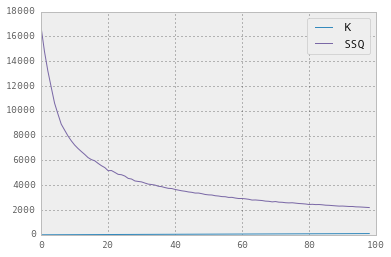

In [132]:
plt.plot(SSQ)
plt.legend(['K','SSQ'])

In [133]:
%%R
dim(array_for_cluster_scaled_PC7)

[1] 1462    7


In [134]:
%%R 
write.csv(array_for_cluster_scaled_PC7,file='../SEPTEMBER_2014/array_for_cluster_scaled_PC7.csv')

In [135]:
array_for_cluster_scaled_PC7=pd.read_csv('../SEPTEMBER_2014/array_for_cluster_scaled_PC7.csv').drop('Unnamed: 0',axis=1)

In [136]:
array_for_cluster_scaled_PC7=array_for_cluster_scaled_PC7.values

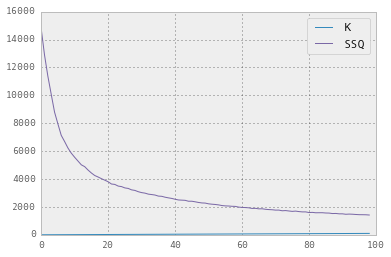

In [137]:
SSQ_PC=[]
for i in xrange(2,100+1):
    kmeans_1=KMeans(n_clusters=i,random_state=1)
    kmeans_1.fit(array_for_cluster_scaled_PC7)
    SSQ_PC.append((i, kmeans_1.inertia_))
plt.plot(SSQ_PC)
plt.legend(['K','SSQ'])

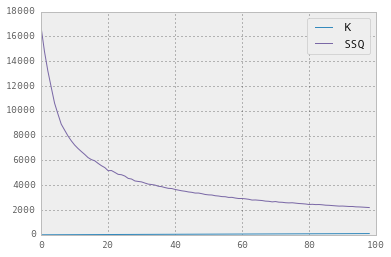

In [192]:
SSQ_PC=[]
for i in xrange(2,100+1):
    kmeans_1=KMeans(n_clusters=i,random_state=1)
    kmeans_1.fit(array_for_cluster_scaled)
    SSQ_PC.append((i, kmeans_1.inertia_))
plt.plot(SSQ_PC)
plt.legend(['K','SSQ'])

Make a heuristic judgment call. K=10. 

In [193]:
kmeans_all=KMeans(n_clusters=10,n_init=10) #random_state=1,
kmeans_all.fit(array_for_cluster_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [190]:
array_for_cluster_scaled_PC7.shape

(1462, 7)

In [196]:
kmeans_all.inertia_

7979.8486085453624

In [202]:
kmeans_all_labs=kmeans_all.labels_

In [203]:
%Rpush kmeans_all_labs

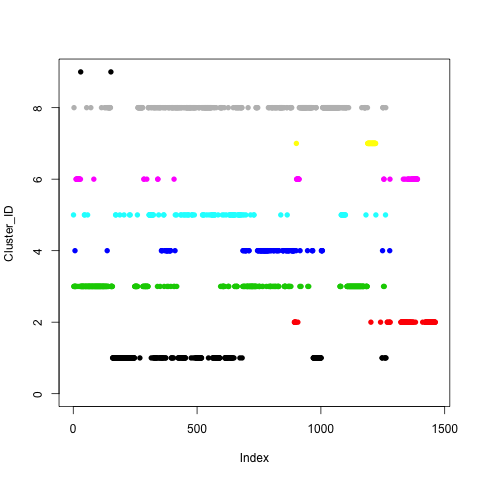

In [204]:
%%R
plot(kmeans_all_labs,col=kmeans_all_labs,pch=16,ylab="Cluster_ID")

In [194]:
kmeans_PCA=KMeans(n_clusters=10,n_init=10) #random_state=1,
kmeans_PCA.fit(array_for_cluster_scaled_PC7)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [197]:
kmeans_PCA.inertia_

6250.005099204468

In [199]:
kmeans_PCA_labs=kmeans_PCA.labels_

In [200]:
%Rpush kmeans_PCA_labs

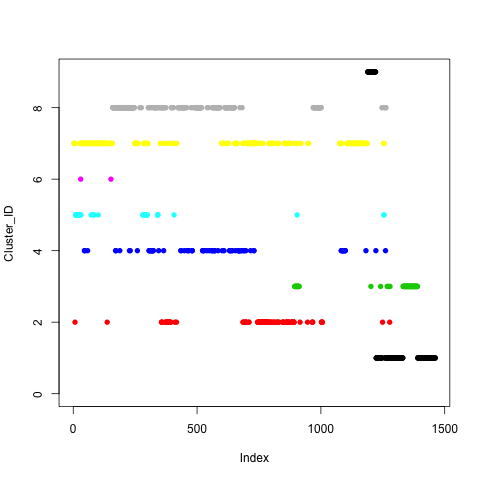

In [201]:
%%R
plot(kmeans_PCA_labs,col=kmeans_PCA_labs,pch=16,ylab="Cluster_ID")

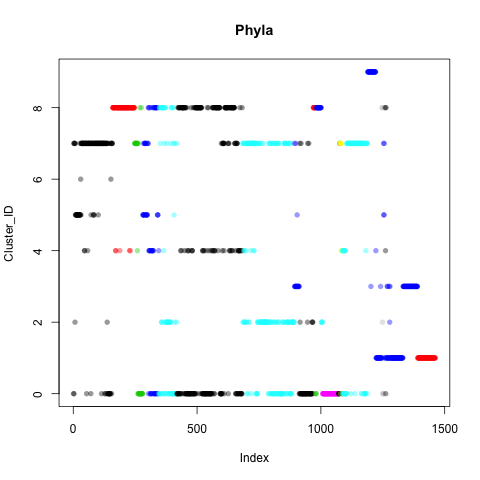

In [327]:
%%R
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(phyla),0.4),pch=16,ylab="Cluster_ID",main='Phyla')

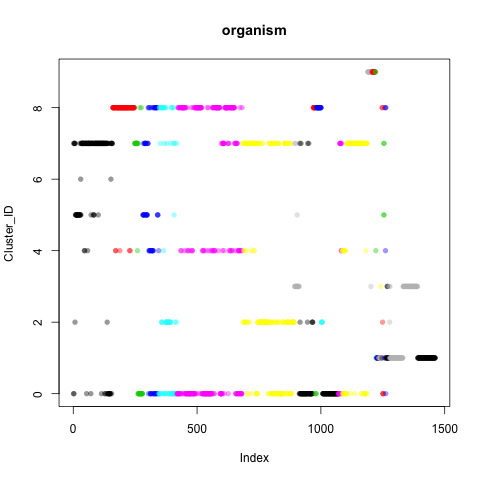

In [329]:
%%R
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(organisms),0.4),pch=16,ylab="Cluster_ID",main="organism")

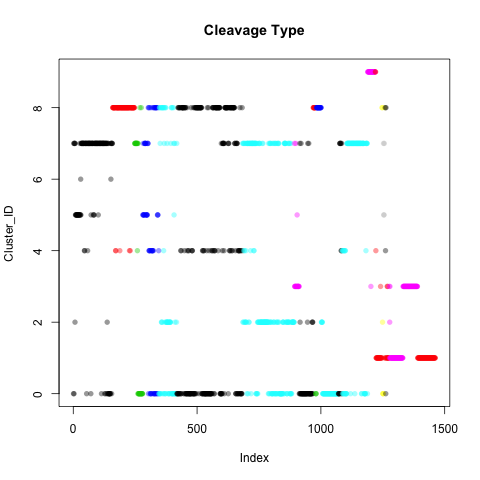

In [331]:
%%R
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(cleavage_type),0.4),pch=16,ylab="Cluster_ID",main='Cleavage Type')

[1] "#00000066" "#FF000066" "#00CD0066" "#0000FF66"


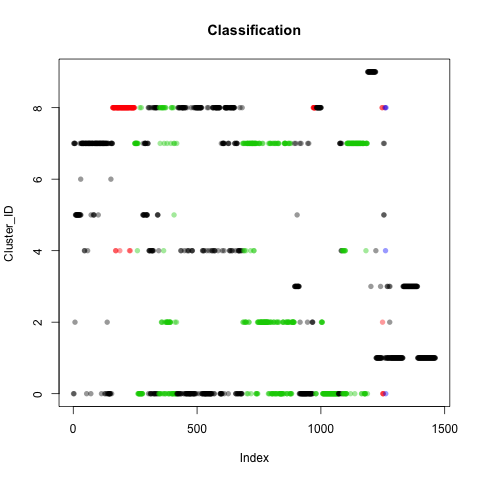

In [330]:
%%R
colors=add.alpha(as.numeric(classification), alpha=0.4)
print(unique(colors))
plot(kmeans_PCA_labs,col=colors,pch=16,ylab="Cluster_ID",main='Classification')
#legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)

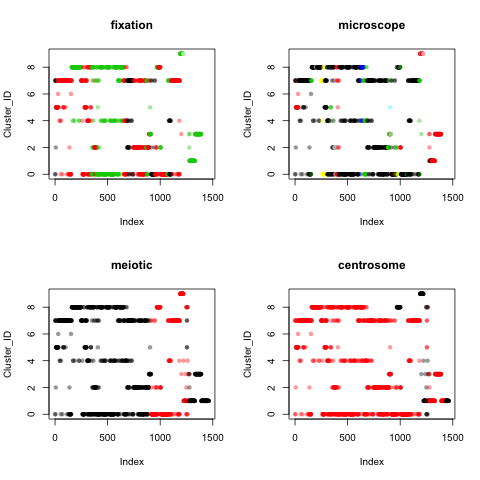

In [328]:
%%R
par(mfrow=c(2,2))
#colors=add.alpha(as.numeric(classification), alpha=0.4)
#print(unique(colors))
#plot(round(array_for_cluster_1[,16]),col=colors,pch=16,ylab="Cluster_ID")
#legend(1300,3.8,c('bd','bpe','bpl','r'),col=unique(colors),pch=16)

plot(kmeans_PCA_labs,col=add.alpha(as.numeric(fixation),0.4)  ,pch=16,ylab="Cluster_ID",main='fixation')
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(microscope),0.4),pch=16,ylab="Cluster_ID",main='microscope')
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(meiotic_plt),0.4),pch=16,main="meiotic",ylab="Cluster_ID")
plot(kmeans_PCA_labs,col=add.alpha(as.numeric(centrosome_plt),0.4),pch=16,main="centrosome",ylab="Cluster_ID")
par(mfrow=c(1,1))

c. K-medoids

In [138]:
from Bio.Cluster import *

In [139]:
clusterid,error,nfound=kmedoids(distance=distancematrix(array_for_cluster_scaled),nclusters=5,npass=10)

In [140]:
clusterid,error,nfound

(array([ 439,   62, 1050, ..., 1050,   62,   62], dtype=int32),
 949.32412269268,
 1)

In [141]:
np.unique(clusterid)

array([  62,  439,  762,  833, 1050], dtype=int32)

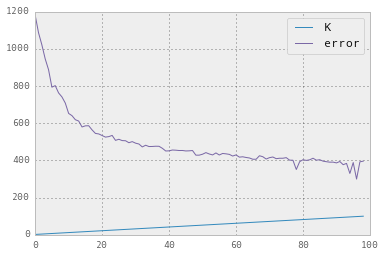

In [142]:
error_PC=[]
for i in xrange(2,100+1):
    clusterid,error,nfound=kmedoids(distance=distancematrix(array_for_cluster_scaled),nclusters=i,npass=10)
    error_PC.append((i, error))
plt.plot(error_PC)
plt.legend(['K','error'])

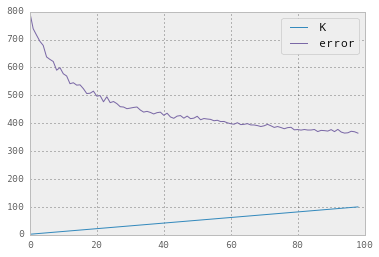

In [143]:
error_PC=[]
for i in xrange(2,100+1):
    clusterid,error,nfound=kmedoids(distance=distancematrix(array_for_cluster_scaled,dist='b'),nclusters=i,npass=10)
    error_PC.append((i, error))
plt.plot(error_PC)
plt.legend(['K','error'])

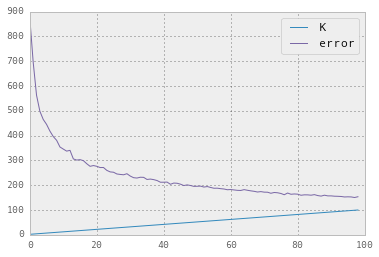

In [144]:
error_PC=[]
for i in xrange(2,100+1):
    clusterid,error,nfound=kmedoids(distance=distancematrix(array_for_cluster_scaled,dist='c'),nclusters=i,npass=10)
    error_PC.append((i, error))
plt.plot(error_PC)
plt.legend(['K','error'])

In [145]:
from sklearn.cluster import MeanShift, estimate_bandwidth